In [49]:
import numpy as np
import pandas as pd
from sklearn.naive_bayes import CategoricalNB
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score
from numbers import Number


## Kilka rozszerzeń klasy **CategoricalNB**
**Cel:**  
- Klasa powinna obsługiwać klasyfikację danych kategorycznych - poprzez dedykowany obiekt klasy **OrdinalEncoder**
- Klasyfikator powinien być odporny na walidację krzyżową (*CategoricalNB* jest **skory do wyjątków**)

#### Przykład 1: Dane  *golf_df*

In [50]:
data = pd.read_csv("./data/golf_df.csv")
print(data)
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values
ylab = np.unique(y)[::-1]       # raczej ("yes", "no") niż odwrotnie
y = (y == 'no').astype(int)     # opcjonalnie
print("Decyzje: ",ylab)

     Outlook Temperature Humidity  Windy Play
0      sunny         hot     high  False   no
1      sunny         hot     high   True   no
2   overcast         hot     high  False  yes
3      rainy        mild     high  False  yes
4      rainy        cool   normal  False  yes
5      rainy        cool   normal   True   no
6   overcast        cool   normal   True  yes
7      sunny        mild     high  False   no
8      sunny        cool   normal  False  yes
9      rainy        mild   normal  False  yes
10     sunny        mild   normal   True  yes
11  overcast        mild     high   True  yes
12  overcast         hot   normal  False  yes
13     rainy        mild     high   True   no
Decyzje:  ['yes' 'no']


In [51]:
enc = OrdinalEncoder()
enc.fit(X)
print("Attributes:")
for cat in enc.categories_:
    print(cat)
X_ = enc.transform(X)
print("Data [:5]:", X_[:5], sep="\n")

Attributes:
['overcast' 'rainy' 'sunny']
['cool' 'hot' 'mild']
['high' 'normal']
[False True]
Data [:5]:
[[2. 1. 0. 0.]
 [2. 1. 0. 1.]
 [0. 1. 0. 0.]
 [1. 2. 0. 0.]
 [1. 0. 1. 0.]]


**Cel (cd):**  

- Akceptacja danych *częściowych*: brak wartości zgłaszany jako `np.nan`
- Akceptacja danych *nierozpoznanych* - niedostępnych w trakcie **fit()**

In [52]:
x = np.asarray(["sunny","hot","normal",True], dtype=object)
# without 'dtype' the last value is changed to string 'True'
x_ = enc.transform(x[None,:])
print(x,"-->",x_)
x3 = X[3].copy()            # of shape (4,), change to (1,4)!
x3[2] = np.nan
# x3_ = enc.transform(x3[None,:])           # of shape (1,4)
# ValueError: Found unknown categories [nan] in column 2 during transform
# ... but - after a small change ...
enc.handle_unknown = 'use_encoded_value'
x3_ = enc.transform(x3[None,:])
x4 = X[4:6].copy()          # of shape (2,4)
x4[0,0] = "fine"
x4_ = enc.transform(x4)
print(x3_,x4_, sep='\n')
print(X[3:6])

['sunny' 'hot' 'normal' True] --> [[2. 1. 1. 1.]]
[[ 1.  2. nan  0.]]
[[nan  0.  1.  0.]
 [ 1.  0.  1.  1.]]
[['rainy' 'mild' 'high' False]
 ['rainy' 'cool' 'normal' False]
 ['rainy' 'cool' 'normal' True]]


Wartość parametru  `.handle_unknown = 'use_encoded_value'`  blokuje z kolei akceptowanie wartości `np.nan` w fazie **fit()**.  
Stąd pomysł na rozszerzenie klasy OrdinalEncoder:

In [53]:
class OrdinalNanEncoder(OrdinalEncoder):    # Dopuszcza nan's dla uczących i dla transformacji
                                            # W trakcie uczenia ewent. None's traktuje jak etykiety
    def fit(self, X, y=None):
        self.handle_unknown = "error"       # default
        return super().fit(X,y)

    def transform(self, X):
        self.handle_unknown = 'use_encoded_value'
        return super().transform(X)

... i włączenie nowej klasy do rozszerzenia `CategoricalNanNB(CategoricalNB)`:
### CategoricalNanNB(CategoricalNB)

In [54]:
class CategoricalNanNB(CategoricalNB):
    enc: OrdinalNanEncoder
    n_features_in_: int                     # pole jest w BaseEstimator,

    def _fit(self, y):                              # wyznacza etykiety klas oraz a'priori  `logP(Y=i)`
        classes, class_counts = np.unique(y, return_counts=True)
        self.classes_ = classes
        self.class_log_prior_ = np.log(class_counts) - np.log(class_counts.sum())

    def fit(self, X, y, encoder=None, **kwargs):
        self._fit(y)                                # `protected` fragment fit() zależny od  y
        self.enc = OrdinalNanEncoder() if encoder is None else encoder
        enc = self.enc
        if not hasattr(enc, "categories_"):         # jeśli encoder enc nie był wcześniej uczony
            enc.fit(X)
        self.n_features_in_ = X.shape[1]

        for j in range(self.n_features_in_):
            cat = enc.categories_[j][-1]
            if isinstance(cat, Number) and np.isnan(cat):       # pomijamy "nan", zostają  None - jeśli są
                enc.categories_[j] = enc.categories_[j][:-1]    # można usunąć końce zawierające nan
        self._count(X, y)

    def _count(self, X, y):                         # inicjalizacja liczników / zliczanie par
        X_ = self.enc.transform(X)
        n_classes = self.classes_.size
        n_features = self.n_features_in_
        n_categories = [self.enc.categories_[j].shape[0] for j in range(n_features)]
        self.category_count_ = [np.zeros((n_classes, n_categories[j])) for j in range(n_features)]
        for i in range(n_classes):
            mask_i = y == self.classes_[i]
            for j in range(n_features):
                cat_count = self.category_count_[j]
                indices, counts = np.unique(X_[mask_i, j], return_counts=True)      # zlicza też nan's
                if np.isnan(indices[-1]):                                           # ... ale pomija wartości
                    indices, counts = indices[:-1], counts[:-1]                     # gdyż są na końcu!
                cat_count[i, indices.astype(int)] += counts
        self._update_feature_log_prob(self.alpha)

    # ...

W trakcie uczenia nowego klasyfikatora można wskazać *encoder* np. z listą kategorii o danym porządku wartości...

W fazie predykcji klasyfikator dokonuje transformacji danych testowych **Z** - za pomocą funkcji

    def _check_X(self, Z):                          
        Z_ = self.enc.transform(Z)
        return Z_

W przypadku pracy z parą zbiorów **X_train**,  **X_test**  jest możliwe, że któreś z wartości nominalnych danych testowych **X_test** nie zostaną rozpoznane na liście wewnętrznego encodera w fazie **fit(X_train, y)**  -- pojawią się jako *nowe/nieznane*, a wewnętrzna transformacja przypisze im wartość  **np.nan**.   
Taka sytuacja jest naturalna w trakcie wielokrotnych *walidacji krzyżowych.*

Podstawę predykcji dla danej tablicy danych nominalnych  **Z --> Z_** $\equiv[z_{hj}]$ wymiaru $m\times n_\text{features in}$
stanowią prawdopodobieństwa warunkowe $P(X=z_{h(.)}\,|\,Y=i)$, a dokładniej ich logarytmy
przechowywane w tablicy **clp=cond_log_proba(Z)** wymiaru $m\times n_\text{classes}$ i wyznaczane z warunku NB
$$ \text{clp}[h,i] = \sum_j \begin{cases}\log P(Z=z_{hj}|\,Y=i),& \text{ gdy }z_{hj}\ne \text{nan}\\
0,& \text{ gdy }z_{hj}= \text{nan}
\end{cases}$$
Stosowny algorytm sumujący logarytmy i uwzględniający możliwe braki wartości atrybutów realizuje metoda  **cond_log_proba**:

In [55]:
class CategoricalNanNB(CategoricalNB):
    # ...
    def cond_log_proba(self, Z):    # log( P(X=z|Y=i) )
        Z_ = self._check_X(Z)       # categorial --> numbered or nan's
        n_classes = self.classes_.size
        clp = np.zeros((Z_.shape[0], n_classes))
        for j in range(self.n_features_in_):
            z_j = Z_[:, j]
            j_nans = np.isnan(z_j)
            z_j_ints = z_j[~j_nans].astype(int)     # TE są całkowite
            clp[~j_nans, :] += self.feature_log_prob_[j][:, z_j_ints].T
        return clp

    def _joint_log_likelihood(self, Z):
        clp = self.cond_log_proba(Z)
        return clp + self.class_log_prior_

    def predict_log_proba(self, Z):
        from scipy.special import logsumexp
        jll = self._joint_log_likelihood(Z)
        log_prob = logsumexp(jll, axis=1)
        return jll - log_prob[:, None]

    def predict(self, Z):
        prob = self.predict_proba(Z)
        return self.classes_.take(prob.argmax(1))


Ostatnie dwie z podanych wyżej metod zastępują analogiczne metody klasy nadrzędnej i pomijają przeniesioną do *cond_log_proba* transformację danych.

Predykcja opiera się na estymowanych prawdopodobieństwach:

In [56]:
from NB_ext import CategoricalNanNB, OrdinalNanEncoder
cnf = CategoricalNanNB()
cnf.fit(X,y)
print(x3, cnf.predict_proba(x3[None,:]), sep=": \t")
print(X[3], cnf.predict_proba(X[3:4]), sep=": \t")
print("Prawdopodobieństwa i przynależność \ndo klas:", ylab)
probs = cnf.predict_proba(X)
for i in range(y.shape[0]):
    st = "" if y[i]==cnf.predict(X[i:i+1]) else "<- {0}".format(X[i])
    print("{0:2}: [{1:6.4f},{2:6.4f}], {3}".format(i, *probs[i], y[i]),st)


['rainy' 'mild' nan False]: 	[[0.72525439 0.27474561]]
['rainy' 'mild' 'high' False]: 	[[0.57335388 0.42664612]]
Prawdopodobieństwa i przynależność 
do klas: ['yes' 'no']
 0: [0.3120,0.6880], 1 
 1: [0.1627,0.8373], 1 
 2: [0.7515,0.2485], 0 
 3: [0.5734,0.4266], 0 
 4: [0.8759,0.1241], 0 
 5: [0.7515,0.2485], 1 <- ['rainy' 'cool' 'normal' True]
 6: [0.9190,0.0810], 0 
 7: [0.4305,0.5695], 1 
 8: [0.7987,0.2013], 0 
 9: [0.8546,0.1454], 0 
10: [0.5863,0.4137], 0 
11: [0.6835,0.3165], 0 
12: [0.9297,0.0703], 0 
13: [0.3655,0.6345], 1 



#### Przykład 2.  Dane *credit-g*

In [57]:
data = pd.read_csv("./data/credit-g.csv")
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values
ylab = np.unique(y)[::-1]           # raczej ('good', 'bad') niż odwrotnie
y = (y == 'bad').astype(int)      # opcjonalnie
attributes = data.columns.values
print("Nazwy kolun/atrybutów:",attributes)
print("Przykładowe dane:")
print(X[:2])
print("Decyzje: ",ylab)

Nazwy kolun/atrybutów: ['checking_status' 'duration' 'credit_history' 'purpose' 'credit_amount'
 'savings_status' 'employment' 'installment_commitment' 'personal_status'
 'other_parties' 'residence_since' 'property_magnitude' 'age'
 'other_payment_plans' 'housing' 'existing_credits' 'job' 'num_dependents'
 'own_telephone' 'foreign_worker' 'class']
Przykładowe dane:
[['<0' 6 "'critical/other existing credit'" 'radio/tv' 1169
  "'no known savings'" '>=7' 4 "'male single'" 'none' 4 "'real estate'"
  67 'none' 'own' 2 'skilled' 1 'yes' 'yes']
 ['0<=X<200' 48 "'existing paid'" 'radio/tv' 5951 '<100' '1<=X<4' 2
  "'female div/dep/mar'" 'none' 2 "'real estate'" 22 'none' 'own' 1
  'skilled' 1 'none' 'yes']]
Decyzje:  ['good' 'bad']


In [58]:
numeric = [1, 4, 7, 10, 12, 15, 17]
print("Atrybuty o numerach ",numeric, "nie są nominalne (kategoryjne):")
print(attributes[numeric])
print("Przykładowe wartości:\n", X[:2, numeric])

Atrybuty o numerach  [1, 4, 7, 10, 12, 15, 17] nie są nominalne (kategoryjne):
['duration' 'credit_amount' 'installment_commitment' 'residence_since'
 'age' 'existing_credits' 'num_dependents']
Przykładowe wartości:
 [[6 1169 4 4 67 2 1]
 [48 5951 2 2 22 1 1]]


Atrybuty nominalne i numeryczne możemy rozdzielić (a wraz z nimi cały zbiór danych X), korzystając z dwu uzupełniających się *masek logicznych*. W ten sposób **X = [Xc, Xn]**, gdzie:

In [59]:
n_mask = [(i in numeric) for i in range(X.shape[1])]
c_mask = np.logical_not(n_mask)
Xc = X[:, c_mask]       # categorical
Xn = X[:, n_mask]       # = X[:, numeric], dane liczbowe

from NB_ext import CategoricalNanNB, OrdinalNanEncoder
clf = CategoricalNanNB()
clf.fit(Xc,y)         # encoder=...   -może być jawnie wskazany i wcześniej dopasowany
for i in range(4):
    print(i,  clf.enc.categories_[i])  # enc.categories_[0], enc.categories_[3], było przed zmianą:


0 ["'no checking'" '0<=X<200' '<0' '>=200']
1 ["'all paid'" "'critical/other existing credit'" "'delayed previously'"
 "'existing paid'" "'no credits/all paid'"]
2 ["'domestic appliance'" "'new car'" "'used car'" 'business' 'education'
 'furniture/equipment' 'other' 'radio/tv' 'repairs' 'retraining']
3 ["'no known savings'" '100<=X<500' '500<=X<1000' '<100' '>=1000']


Predykcja na podstawie danych nominalnych zawartych w **Xc**:

Macierz błędów klasyfikatora:
[[601  99]
 [138 162]]


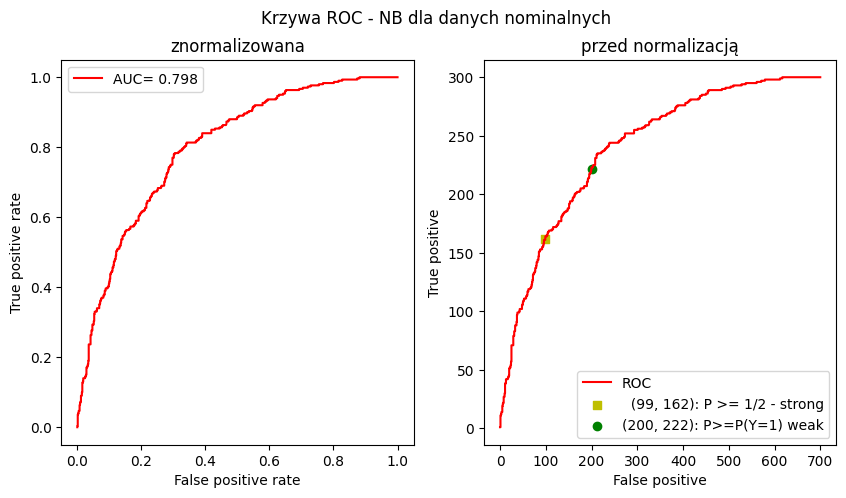

Macierz błędów klasyfikatora (weak):
[[500 200]
 [ 78 222]]


In [60]:
from matplotlib import pyplot as plt
from NB_ext import ROC, AUC, conf_mtx
y_pred = clf.predict(Xc)
mtx = conf_mtx(y,y_pred)
print('Macierz błędów klasyfikatora:')
print(mtx)
y_proba = clf.predict_proba(Xc)[:,1]
fP, tP, _ = roc_curve(y, y_proba)
auc = roc_auc_score(y, y_proba)
fig, (ax0, ax1) = plt.subplots(1,2, figsize=(10,5))
ax0.plot(fP,tP, color="r", label=f"AUC={auc:6.3f}");
fig.suptitle("Krzywa ROC - NB dla danych nominalnych")
ax0.set_xlabel("False positive rate")
ax0.set_ylabel("True positive rate")
ax0.set_title("znormalizowana")
ax0.legend();

FP,TP = ROC(y, y_proba)
pr_apriori = TP[-1]/(len(y))        # akt. 3/10
y_suspect = (y_proba>=pr_apriori).astype(int)    # ... gdy  P(Y=1|x) >= P(Y=1)
mtxw = conf_mtx(y,y_suspect)
fps,tps = mtx[:,1]
fpw,tpw = mtxw[:,1]
ax1.plot(FP,TP, color="r", label="ROC");
ax1.scatter(fps,tps, color="y", marker='s', label=f"  {fps,tps}: P >= 1/2 - strong")
ax1.scatter(fpw,tpw, color="green", marker='o', label=f"{fpw,tpw}: P>=P(Y=1) weak")

ax1.set_xlabel("False positive")
ax1.set_ylabel("True positive")
ax1.set_title("przed normalizacją")
ax1.legend();
plt.show()
print('Macierz błędów klasyfikatora (weak):')
print(mtxw)


*Słaba* wersja klasyfikatora opiera decyzję na **podejrzeniu przynależności do klasy**, jeśli w konkretnym przypadku pomiar danej opisującej  **x**  zwiększa wstępne, aprioryczne prawdopodobieństwo.   
*Podejrzenie* charakteryzują nierówności
$$P(Y=1\,|\,X=x)\geq P(Y=1)\quad\Longleftrightarrow\quad P(Y=0\,|\,X=x)\leq P(Y=0)$$

### Walidacja krzyżowa
Zgodnie z zapowiedzią możemy uzyskać bardziej wiarygodną, ale mniej optymistyczną ocenę jakości klasyfikatora, stosując $r-$ krotną walidację krzyżową, na którą składają się dwie funkcje zdefiniowane np. w pliku NB_ext.py

In [61]:
from NB_ext import xStratification, xValidation
test_folds = xStratification(y, rand=np.random.default_rng(0))     # random - a może zatem jeszcze średnia ze 100?
# r = 10      # domyślnie, błąd CategoricalNB dla: (n_splits=2, r=236) i (3, 1506)
y_probs =  xValidation(clf, Xc, y, test_folds)
auc = roc_auc_score(y, y_probs)
print(f"auc_CategoricalNanNB (10-x, credit-g): {auc:6.4f}")   # 0.76963333

mtx_w = conf_mtx(y, (y_probs >= pr_apriori).astype(int))
print("CategoricalNanNB for credit-g (weak, 10-x):", mtx_w, sep="\n")

mtx_s = conf_mtx(y, (y_probs >= .5).astype(int))
print("CategoricalNanNB for credit-g (strong, 10-x):", mtx_s, sep="\n")


auc_CategoricalNanNB (10-x, credit-g): 0.7696
CategoricalNanNB for credit-g (weak, 10-x):
[[487 213]
 [ 87 213]]
CategoricalNanNB for credit-g (strong, 10-x):
[[589 111]
 [154 146]]


#### BŁĄD
Przewidywany błąd oryginalnej klasy  **CategoricalNB** nie tak łatwo uchwycić, ale ograniczając *nieco* losowość, dostajemy np.

In [62]:
enc = OrdinalEncoder(); enc.fit(Xc)
Xc_ = enc.transform(Xc)
clf_ = CategoricalNB()

n_splits, r = 3, 1506         # błąd też dla: n_splits=2, r=236
test_folds = xStratification(y, n_splits=n_splits, rand=np.random.default_rng(r))     # random - a może zatem jeszcze średnia ze 100?
try:
    y_probs =  xValidation(clf_, Xc_, y, test_folds)
except:
    print("-->Błąd x-walidacji dla ", clf_)
y_probs =  xValidation(clf, Xc, y, test_folds)
print("\nA dla {0} wszystko OK:".format(clf))
auc = roc_auc_score(y, y_probs)
print(f"auc_CategoricalNanNB ({n_splits}-x, credit-g): {auc:6.4f}")   # 0.76963333

mtx_w = conf_mtx(y, (y_probs >= pr_apriori).astype(int))
print(f"CategoricalNanNB for credit-g (weak, {n_splits}-x):", mtx_w, sep="\n")

mtx_s = conf_mtx(y, (y_probs >= .5).astype(int))
print(f"CategoricalNanNB for credit-g (strong, {n_splits}-x):", mtx_s, sep="\n")



-->Błąd x-walidacji dla  CategoricalNB()

A dla CategoricalNanNB() wszystko OK:
auc_CategoricalNanNB (3-x, credit-g): 0.7667
CategoricalNanNB for credit-g (weak, 3-x):
[[492 208]
 [ 86 214]]
CategoricalNanNB for credit-g (strong, 3-x):
[[589 111]
 [151 149]]


### MixedNB(ClassifierMixin, BaseEstimator)
Poprawa efektywności klasyfikatora **CategoricalNanNB** wymaga uwzględnienia danych liczbowych pominiętych w przedstawionej wyżej koncepcji. Jeśli przyjąć,  **X=(Xc,Xn)**  oznacza podział atrybutów (i danych) na dwie grupy - kategoryjne i numeryczne, to naiwne założenie relatywnej niezależności grup prowadzi do wzorów:
$$\begin{align}
P(X=(x',x'')\,|\,Y=j)&=P(X\!c=x'|\,Y=j)P(X\!n=x''|\,Y=j)\\
P(Y=j\,|\,X=(x',x'')) &=\frac{P(X\!c=x'|\,Y=j)P(X\!n=x'',Y=j)}{P(X=(x',x''))}=\frac{P(X\!c=x'|\,Y=j)P(X\!n=x'',Y=j)}{\sum_a P(X\!c=x'|\,Y=a)P(X\!n=x'',Y=a)}\\
&= \frac{P(X\!c=x'|\,Y=j)P(Y=j\,|\,X\!n=x'')}{\sum_a P(X\!c=x'|\,Y=a)P(Y=a\,|\,X\!n=x'')}
\end{align}$$
Jak zwykle, do estymacji (i porównania) wystarczają liczniki, zależne od dwu rozkładów: naiwnego bayesowskiego $P_{X'}$ i odrębnego, wybranego arbitralnie $P_{X''}$. Po zlogarytmowaniu liczników, wyznaczamy sumy postaci  **cond_log_proba(x',j) + log_proba(x",j)**  - dla wszystkich klas i ich indeksów **j**.

Nowa klasa wymaga wskazania dodatkowego klasyfikatora obsługującego dane liczbowe, np.:

In [63]:
from NB_ext import MixedNB
from sklearn.linear_model import LogisticRegression
cl_mix = MixedNB(LogisticRegression(max_iter=1000))

Dopasowanie klasyfikatora **MixedNB** do konkretnych danych **(X,y)** wymaga wskazania, które atrybuty zaliczyć np. do liczbowych (numerycznych). Przekazana jako opcjonalny parametr maska pozostaje wewnętrznym stanem klasyfikatora i może być wykorzystana w procesie walidacji krzyżowej.

#### Wybrane szczegóły implementacji:

In [64]:
from sklearn.base import ClassifierMixin, BaseEstimator
class MixedNB(ClassifierMixin, BaseEstimator):
    cmask: np.ndarray
    claNB: CategoricalNanNB = CategoricalNanNB()

    def __init__(self, classifier, cat_nb=None):  # możliwa jakaś szczególna wersja cat_nb
        self.classifier = classifier              # obiekt, nie klasa
        if cat_nb: self.claNB = cat_nb
        self.n_classes: int; self.n_features: int

    def fit(self, X, y, nums: list[int] = None, **kwargs):      # raz wpisana maska staje się domyślna
        num_a = X.shape[1]
        self.n_features = num_a
        if nums is not None:
            nmask = np.asarray([(i in nums) or (i-num_a in nums) for i in range(num_a)])
            self.cmask = ~nmask
        else:
            nmask = ~self.cmask
        Xc, Xn = X[:, ~nmask], X[:, nmask]     # nominal, numeric(gaussian?)
        claNB = self.claNB
        claNB.fit(Xc, y)
        self.n_classes = self.claNB.classes_.size
        cla = self.classifier
        cla.fit(Xn, y)

    def predict_log_proba(self, Z):
        Zc = Z[:, self.cmask]
        Zn = Z[:, ~self.cmask]
        clp_c = self.claNB.cond_log_proba(Zc)  # sum(log P_NB(x|c))
        log_pr_n = self.classifier.predict_log_proba(Zn)  # log P_LR(c|x)
        cll = clp_c + log_pr_n
        # normalize by sumexp
        from scipy.special import logsumexp
        log_prob_rel = logsumexp(cll, axis=1)
        return cll - log_prob_rel[:, None]

    # ...


Pozostałe funkcje predykcji **prodict_proba** i **predict** powtarzają standardowy kod -- nie mogą skorzystać z dziedziczenia. Zamiast tego można wprowadzić *próg predykcji*, domyślnie równy 0.5

[[0.98464103 0.01535897]]
...a w środku
[[0.96128406 0.03871594]]
[[0.85764381 0.14235619]]
Macierz błędów klasyfikatora:
[[602  98]
 [134 166]]
Macierz błędów klasyfikatora (weak):
[[513 187]
 [ 68 232]]


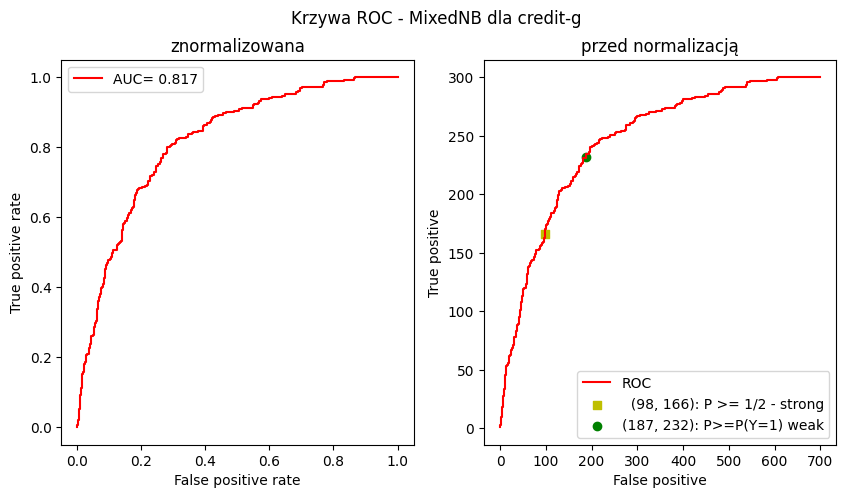

In [65]:
data = pd.read_csv("./data/credit-g.csv")
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values
ylab = np.unique(y)[::-1]           # raczej ('good', 'bad') niż odwrotnie
y = (y == 'bad').astype(int)        # opcjonalnie
numeric = [1, 4, 7, 10, 12, 15, 17]
cl_mix.fit(X, y, nums=numeric)
print(cl_mix.predict_proba(X[2:3]))
print("...a w środku")
print(cl_mix.claNB.predict_proba(Xc[2:3]))
print(cl_mix.classifier.predict_proba(Xn[2:3]))

y_pred = cl_mix.predict(X)
mtx = conf_mtx(y,y_pred)
print('Macierz błędów klasyfikatora:')
print(mtx)
y_proba = cl_mix.predict_proba(X)[:,1]
fP, tP, _ = roc_curve(y, y_proba)
auc = roc_auc_score(y, y_proba)
fig, (ax0, ax1) = plt.subplots(1,2, figsize=(10,5))
ax0.plot(fP,tP, color="r", label=f"AUC={auc:6.3f}");
fig.suptitle("Krzywa ROC - MixedNB dla credit-g")
ax0.set_xlabel("False positive rate")
ax0.set_ylabel("True positive rate")
ax0.set_title("znormalizowana")
ax0.legend();

FP,TP = ROC(y, y_proba)
pr_apriori = TP[-1]/(len(y))        # akt. 3/10
y_suspect = (y_proba>=pr_apriori).astype(int)    # ... gdy  P(Y=1|x) >= P(Y=1)
mtxw = conf_mtx(y,y_suspect)
print('Macierz błędów klasyfikatora (weak):')
print(mtxw)
fps,tps = mtx[:,1]
fpw,tpw = mtxw[:,1]
ax1.plot(FP,TP, color="r", label="ROC");
ax1.scatter(fps,tps, color="y", marker='s', label=f"  {fps,tps}: P >= 1/2 - strong")
ax1.scatter(fpw,tpw, color="green", marker='o', label=f"{fpw,tpw}: P>=P(Y=1) weak")

ax1.set_xlabel("False positive")
ax1.set_ylabel("True positive")
ax1.set_title("przed normalizacją")
ax1.legend();
plt.show()


A teraz 10-krotna walidacja krzyżowa:

In [66]:
test_folds = xStratification(y, rand=np.random.default_rng(0))     # random - a może zatem jeszcze średnia ze 100?
# r = 10      # domyślnie, błąd CategoricalNB dla: (n_splits=2, r=236) i (3, 1506)
y_probs =  xValidation(cl_mix, X, y, test_folds)
auc = roc_auc_score(y, y_probs)
print(f"auc_MixedNB+LogisticRegr (10-x, credit-g): {auc:6.4f}")   # 0.76963333

mtx_w = conf_mtx(y, (y_probs >= pr_apriori).astype(int))
print("MixedNB+LogisticRegr for credit-g (weak, 10-x):", mtx_w, sep="\n")

mtx_s = conf_mtx(y, (y_probs >= .5).astype(int))
print("MixedNB+LogisticRegr for credit-g (strong, 10-x):", mtx_s, sep="\n")


auc_MixedNB+LogisticRegr (10-x, credit-g): 0.7865
MixedNB+LogisticRegr for credit-g (weak, 10-x):
[[501 199]
 [ 78 222]]
MixedNB+LogisticRegr for credit-g (strong, 10-x):
[[588 112]
 [143 157]]


#### Dla porównania - mix w ramach NB: Categorical+Gaussian

In [67]:
from sklearn.naive_bayes import GaussianNB
from NB_ext import MixedNB

clNiG = MixedNB(GaussianNB())
clNiG.fit(X, y, numeric)
y_probs =  xValidation(clNiG, X, y, test_folds)
auc = roc_auc_score(y, y_probs)
print(f"auc_MixedNB+GaussianNB (10-x, credit-g): {auc:6.4f}")   # 0.76963333

mtx_w = conf_mtx(y, (y_probs >= pr_apriori).astype(int))
print("MixedNB+GaussianNB for credit-g (weak, 10-x):", mtx_w, sep="\n")

mtx_s = conf_mtx(y, (y_probs >= .5).astype(int))
print("MixedNB+GaussianNB for credit-g (strong, 10-x):", mtx_s, sep="\n")
print("\nNa przykład:")
clNiG.fit(X, y, numeric)
print(clNiG.predict_proba(X[2:3]))
print("...a w środku")
print(clNiG.claNB.predict_proba(Xc[2:3]))
print(clNiG.classifier.predict_proba(Xn[2:3]))


auc_MixedNB+GaussianNB (10-x, credit-g): 0.7818
MixedNB+GaussianNB for credit-g (weak, 10-x):
[[525 175]
 [ 90 210]]
MixedNB+GaussianNB for credit-g (strong, 10-x):
[[603  97]
 [158 142]]

Na przykład:
[[0.9882394 0.0117606]]
...a w środku
[[0.96128406 0.03871594]]
[[0.88759917 0.11240083]]
